<a href="https://colab.research.google.com/github/cocobridge696/ML/blob/main/IMDB_sentiment_BoW%2CConv1D%2CMultiCNN_Bclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import scipy as scipy
import os

In [16]:
train,test=tfds.load(name='imdb_reviews/plain_text',split=['train','test'],batch_size=-1,as_supervised=True)
train,trlabel=tfds.as_numpy(train)
test,telabel=tfds.as_numpy(test)
print(type(train[0]))

<class 'bytes'>


# Bag of words method
vectorize data without keeping order

In [17]:
#Bag of words
#convert test to ngrams and vectorize
def ngram_vect(train,trlabel,test):
  ngram_rang=(1,2) #uni and bigrams
  top_k=20000 #feature limit
  min_freq=2 #freq below this will be discarded
  token_mode='word'
  kwargs={'ngram_range':ngram_rang,'dtype':'int32','strip_accents':'unicode',
  'decode_error':'replace','analyzer':token_mode,'min_df':min_freq}
  vectorizer=TfidfVectorizer(**kwargs,encoding='utf-8')

  train=vectorizer.fit_transform(train) #learn vector vocabulary and vectorize training texts
  test=vectorizer.transform(test)
  
  #remove unimportant features by looking at labels
  #f_classif measures importance of features
  #k is the num of features kept
  selector=SelectKBest(f_classif,k=min(top_k,train.shape[1]))
  selector.fit(train,trlabel)
  train=selector.transform(train).astype('float32')
  test=selector.transform(test).astype('float32')
  return train,test
#bag of words approach- order not taken into account and thus use logistic regression or multilayer perceptrons models
#sparse tensor with form ((indices) value)

When the S/W ratio is small, we’ve found that n-gram models perform better than sequence models. Sequence models are better when there are a large number of small, dense vectors. This is because embedding relationships are learned in dense space, and this happens best over many samples.

In [18]:
#bag of words model
from tensorflow.keras.layers import Dense,Dropout
def create_NN(lr,input_shape,d_rate):
  model=tf.keras.models.Sequential()
  model.add(Dropout(rate=d_rate,input_shape=input_shape))
  model.add(Dense(units=64,activation='relu'))
  model.add(Dropout(rate=d_rate))
  model.add(Dense(units=64,activation='relu'))
  model.add(Dropout(rate=d_rate))
  model.add(Dense(units=1,activation='sigmoid'))
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr),loss='binary_crossentropy',metrics=['accuracy'])
  return model

In [19]:
#vectorize using bag of words
train_bw,test_bw=ngram_vect(train,trlabel,test)

#convert to array from sparse tensor
train_bw=scipy.sparse.csr_matrix.toarray(train_bw)
test_bw=scipy.sparse.csr_matrix.toarray(test_bw)

#Bag of words model
lr=1e-3
epoch=100
batch=128
d_rate=0.2
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2)
input_shape=train_bw.shape[1:]

model=create_NN(lr,input_shape,d_rate)

history=model.fit(x=train_bw,y=trlabel,batch_size=batch,
                  epochs=epoch,validation_data=(test_bw,telabel),
                  callbacks=callback)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:1817: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
196/196 [==============================] - 18s 85ms/step - loss: 0.3668 - accuracy: 0.8706 - val_loss: 0.2356 - val_accuracy: 0.9044
Epoch 2/100
196/196 [==============================] - 15s 76ms/step - loss: 0.1462 - accuracy: 0.9467 - val_loss: 0.2442 - val_accuracy: 0.9031
Epoch 3/100
196/196 [==============================] - 13s 69ms/step - loss: 0.0933 - accuracy: 0.9674 - val_loss: 0.2818 - val_accuracy: 0.8945


# Sequence methods

vectorize data maintaining order![alt text](https://)

In [20]:
#sequence vectors
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text

def sequence_vector(train,test):
  top_k=20000
  max_seq_len=500
  #convert from bytes to text for tokenizer
  train=[str(x) for x in train]
  test=[str(x) for x in test]

  #create vocab
  tokenizer=text.Tokenizer(num_words=top_k)
  tokenizer.fit_on_texts(train)
  
  #vectorize 
  train=tokenizer.texts_to_sequences(train)
  test=tokenizer.texts_to_sequences(test)
  
  max_length=len(max(train,key=len))
  if max_length>max_seq_len:
    max_length=max_seq_len

  #padd seq at the beginning if they are shorter than max and truncates longer seq at beginning
  train=sequence.pad_sequences(train,maxlen=max_length)
  test=sequence.pad_sequences(test,maxlen=max_length)
  return train,test,tokenizer.word_index

# Conv1D model


In [24]:
#sepCNN (depthwise separable convolutional network) sequence model
#pre-trained embeddings are often useful
def create_sepCNN(lr,layers,filters,kernel_size,d_rate,num_feat,embed_dim,input_shape,pretrained_embedding,embed_matrix):
  from tensorflow.keras.layers import Embedding,Dropout,SeparableConv1D,Dense,GlobalAveragePooling1D,MaxPooling1D
  model=tf.keras.models.Sequential()
  if pretrained_embed:
    model.add(Embedding(input_dim=num_feat,output_dim=embed_dim,
                                      input_length=input_shape[0],weights=[embed_matrix],
                                      trainable=trainable))
  else:
    model.add(Embedding(input_dim=num_feat,output_dim=embed_dim,
                                      input_length=input_shape[0]))
  
  model.add(tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'))
  model.add(GlobalAveragePooling1D())
  model.add(Dropout(rate=d_rate))
  model.add(Dense(24,activation='relu'))
  model.add(Dense(units=1,activation='sigmoid'))
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr),loss='binary_crossentropy',metrics=['accuracy'])
  return model

In [25]:
#sequence vectorize
train_sq,test_sq,i=sequence_vector(train,test)
input_shape=train_sq.shape[1:]

d_rate=0.2
filters=64
kernel_size=3
pool_size=3
embed_dim=200
pretrained_embed=False
lr=1e-2
layers=2
embed_matrix=None
num_feat=20000 #top k from earlier
model=create_sepCNN(lr,layers,filters,kernel_size,d_rate,num_feat,embed_dim,input_shape,pretrained_embed,embed_matrix)



epoch=100
batch=300
callback=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]
history=model.fit(x=train_sq,y=trlabel,batch_size=batch,
                 epochs=epoch,validation_data=(test_sq,telabel),
                  callbacks=callback)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
84/84 [==============================] - 112s 1s/step - loss: 0.4224 - accuracy: 0.7986 - val_loss: 0.2812 - val_accuracy: 0.8898
Epoch 2/100
84/84 [==============================] - 112s 1s/step - loss: 0.1929 - accuracy: 0.9301 - val_loss: 0.3015 - val_accuracy: 0.8831
Epoch 3/100
84/84 [==============================] - 136s 2s/step - loss: 0.1146 - accuracy: 0.9592 - val_loss: 0.4200 - val_accuracy: 0.8665


**Multichannel CNN**

In [26]:
#Multichannel Conv1D with kernel size dictating ngram size (how many words it takes in this case)
def create_multichannel_cnn(lr,embed_dim,num_feat,input_shape):
  from tensorflow.keras.layers import Conv1D,Dropout,Embedding,MaxPooling1D,Dense,Flatten,Input,concatenate
  
  input1=Input(shape=input_shape[0])
  embed1=Embedding(input_dim=num_feat,output_dim=embed_dim)(input1)
  conv1=Conv1D(kernel_size=4,filters=32,activation='relu')(embed1)
  drop1=Dropout(rate=0.1)(conv1)
  pool1=MaxPooling1D(pool_size=2)(drop1)
  flat1=Flatten()(pool1)

  input2=Input(shape=input_shape[0])
  embed2=Embedding(input_dim=num_feat,output_dim=embed_dim)(input2)
  conv2=Conv1D(kernel_size=6,filters=32,activation='relu')(embed2)
  drop2=Dropout(rate=0.1)(conv2)
  pool2=MaxPooling1D(pool_size=2)(drop2)
  flat2=Flatten()(pool2)

  input3=Input(shape=input_shape[0])
  embed3=Embedding(input_dim=num_feat,output_dim=embed_dim)(input3)
  conv3=Conv1D(kernel_size=8,filters=32,activation='relu')(embed3)
  drop3=Dropout(rate=0.1)(conv3)
  pool3=MaxPooling1D(pool_size=2)(drop3)
  flat3=Flatten()(pool3)
  

  #merge
  merge=concatenate([flat1,flat2,flat3])
  den=(Dense(20,activation='relu'))(merge)
  out=Dense(1,activation='sigmoid')(den)
  model=tf.keras.models.Model(inputs=[input1,input2,input3],outputs=out)
  model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr), metrics=['accuracy'])
  return model


In [27]:
train_sq,test_sq,i=sequence_vector(train,test)
input_shape=train_sq.shape[1:]
num_feat=20000
embed_dim=200
lr=1e-3
model=create_multichannel_cnn(lr,embed_dim,num_feat,input_shape=input_shape)

In [28]:
len(train_sq)



25000

In [29]:
epoch=20
batch=100

history=model.fit(x=[train_sq,train_sq,train_sq],y=trlabel,epochs=epoch,
                  batch_size=batch,validation_data=([test_sq,test_sq,test_sq],telabel),
                  callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2))

Epoch 1/20
250/250 [==============================] - 498s 2s/step - loss: 0.5586 - accuracy: 0.7367 - val_loss: 0.4617 - val_accuracy: 0.8705
Epoch 2/20
250/250 [==============================] - 491s 2s/step - loss: 0.3746 - accuracy: 0.9155 - val_loss: 0.4185 - val_accuracy: 0.8693
Epoch 3/20
250/250 [==============================] - 477s 2s/step - loss: 0.1709 - accuracy: 0.9466 - val_loss: 0.3238 - val_accuracy: 0.8718
Epoch 4/20
250/250 [==============================] - 500s 2s/step - loss: 0.0578 - accuracy: 0.9823 - val_loss: 0.3863 - val_accuracy: 0.8755
Epoch 5/20
250/250 [==============================] - 499s 2s/step - loss: 0.0133 - accuracy: 0.9966 - val_loss: 0.4739 - val_accuracy: 0.8769
Epoch 6/20
250/250 [==============================] - 505s 2s/step - loss: 0.0021 - accuracy: 0.9997 - val_loss: 0.5641 - val_accuracy: 0.8756
Epoch 7/20
250/250 [==============================] - 505s 2s/step - loss: 4.2131e-04 - accuracy: 1.0000 - val_loss: 0.6103 - val_accuracy: 0.

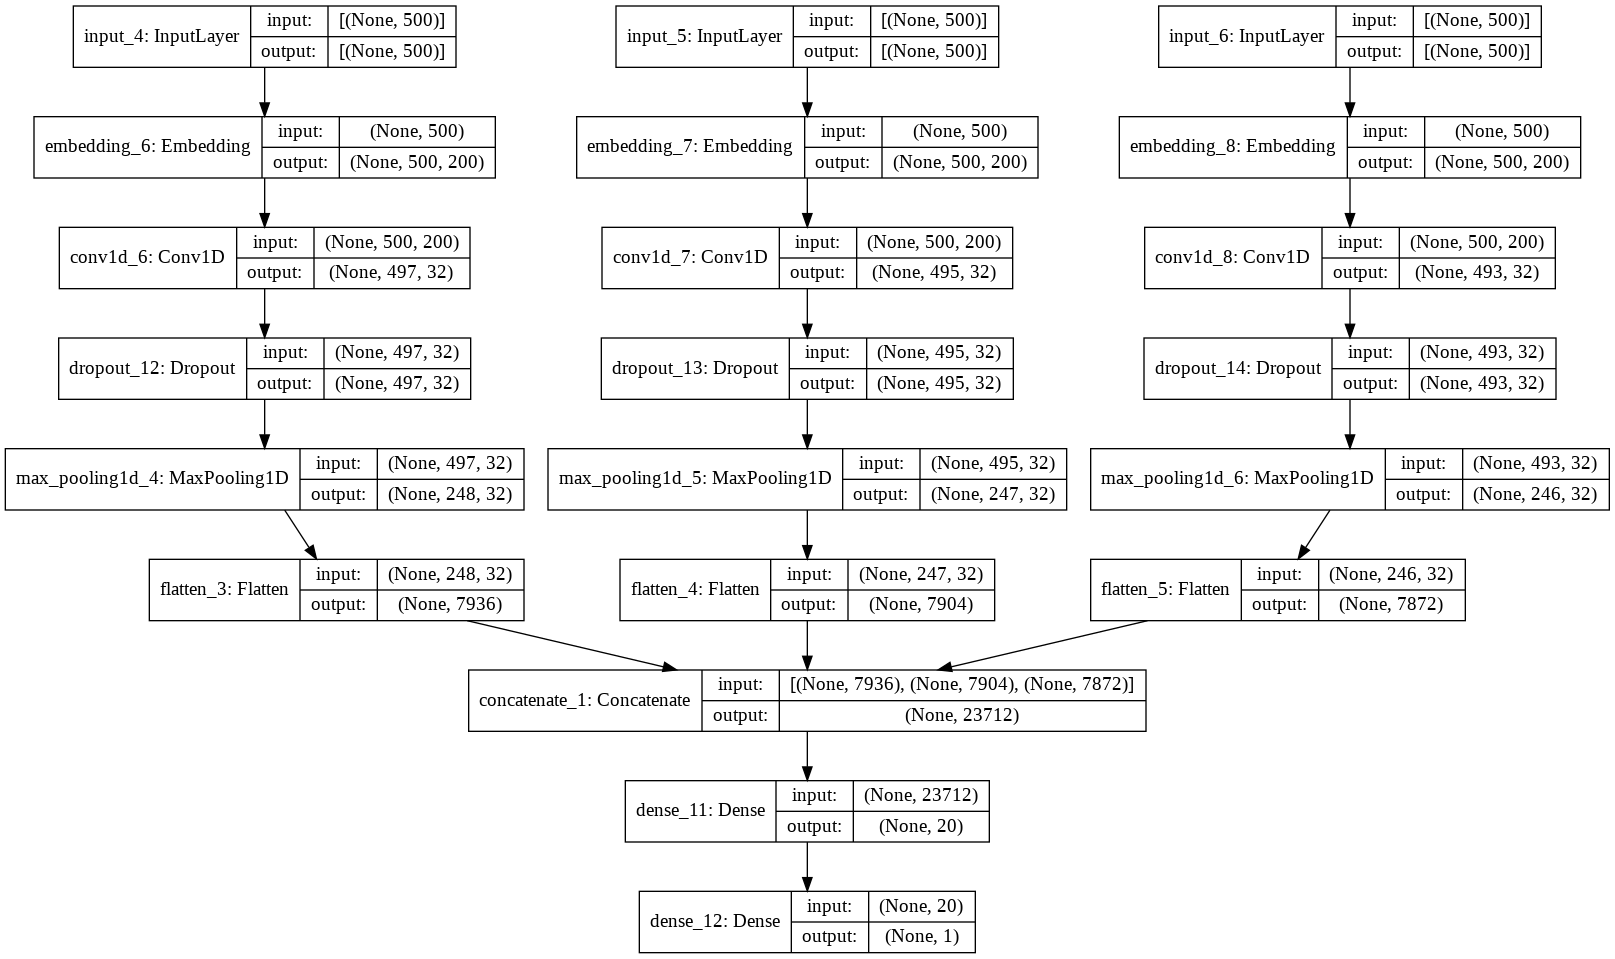

In [30]:
tf.keras.utils.plot_model(model,show_shapes=True)

BoW model acc=90%, CNN model acc=89%, MultiCNN acc=88%